In [1]:
import random
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

C:\Users\SJ\anaconda3\envs\pythonProject\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\SJ\anaconda3\envs\pythonProject\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\SJ\anaconda3\envs\pythonProject\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
torch.cuda.is_available()

True

In [4]:
CFG = {
    'TRAIN_WINDOW_SIZE':90, # 90일치로 학습
    'PREDICT_SIZE':21, # 21일치 예측
    'EPOCHS':10,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':2048,
    'SEED':41
}

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [6]:
train_data = pd.read_csv('train.csv').drop(columns=['제품'])
sale_data = pd.read_csv('sales.csv').drop(columns = ['제품'])
keyword_data = pd.read_csv('brand_keyword_cnt.csv')

In [7]:
train_drop = train_data.drop(train_data.iloc[:, 0:5], axis=1) # 대분류 중분류 소분류 등을 drop해주었음

0         0.747277
1         1.281046
2         2.259259
3         3.459695
4         2.668845
           ...    
15885    12.788671
15886     4.559913
15887     3.884532
15888     2.302832
15889     0.002179
Length: 15890, dtype: float64


In [8]:
def outlier_remove(data, threshold=2.5):
    '''
    IQR 방법을 이용하여 이상치 탐지
    :data : 일별 판매량:
    :threshold : 일반적으로 1.5:
    '''
    q1, q3 = np.percentile(data, [1.5, 98.7])
    IQR = q3 - q1 # IQR 계산

    lower_bound = q1 - (threshold * IQR) # Outlier 판단 Lower Bound 계산
    upper_bound = q3 + (threshold * IQR)  #Outlier 판단 Upper Bound 계산

    filtered_data = [x for x in data if x >= lower_bound and x <= upper_bound]
    outlier = [x for x in data if x not in filtered_data]

    return filtered_data, outlier, q1, q3, IQR, lower_bound, upper_bound

In [ ]:
def make_values_nan(dataframe, target_list):
    '''
    list 받아서 둘다 해당하는 숫자 결측치로 만듬
    dataframe: pandas DataFrame - 결측치를 적용할 DataFrame
    target_list: list - 결측치로 만들기 위해 대상이 되는 리스트
    '''
    # DataFrame의 각 행에 대해 대상 리스트의 값과 동일한 값을 갖는 경우 해당 값을 NaN으로 변경
    for index, row in tqdm(dataframe.iterrows()):
        dataframe.loc[index] = row.apply(lambda x: None if x in target_list[index] else x)

    return dataframe

In [9]:
target_list=[]
for i in range(len(train_drop)):
    b = outlier_remove(train_drop.iloc[i])
    target_list.append(list(set(b[1])))

In [11]:
train_nan = train_drop.copy()
train_nan = make_values_nan(train_nan,target_list)

0it [00:00, ?it/s]

In [13]:
def exponential_smoothing(dataframe, alpha=0.2):
    '''
    지수평활법 함수
    '''
    df = dataframe.T.copy()
    for i in tqdm(range(len(df.T))):
        try:
            smoothed_values = df[i].ewm(alpha=alpha, adjust=False).mean()
            df[i] = df[i].combine_first(smoothed_values)
        except Exception as e:
            df[i] = df[i].fillna(df[i].mean())  # 예외 발생 시 평균값으로 채움

    return df

In [14]:
df = pd.DataFrame
df = exponential_smoothing(train_nan, alpha=0.2)

  0%|          | 0/15890 [00:00<?, ?it/s]

In [16]:
train_exp = df.T.copy()
train_exp = train_exp.apply(lambda row: row.fillna(row.mean()), axis=1)
train_exp.isnull().sum()

In [18]:
train_exp = train_exp.astype(int)

In [19]:
train_data = pd.read_csv('train.csv').drop(columns=['제품'])

In [20]:
train_data = train_data.iloc[:,0:5]

In [21]:
train_data = pd.concat([train_data,train_exp], axis=1)

In [24]:
keyword_data.columns[:]

Index(['브랜드', '2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
       '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08', '2022-01-09',
       ...
       '2023-03-26', '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30',
       '2023-03-31', '2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04'],
      dtype='object', length=460)

In [25]:
# Label Encoding : 날짜(열이름)를 0~458로 인코딩
label_encoder = LabelEncoder()
label_encoder.fit(keyword_data.columns[1:])
encoded_columns = label_encoder.transform(keyword_data.columns[1:])


In [26]:
#keyword 검색량 결측치를 0으로 변환.
for i in tqdm(keyword_data.columns[1:]):
    keyword_data[i]=keyword_data[i].fillna(0.0)

  0%|          | 0/459 [00:00<?, ?it/s]

In [27]:
#결측치 갯수 확인
a=0
for i in tqdm(keyword_data.columns[1:]):
    a=a+keyword_data[i].isnull().sum()
a

  0%|          | 0/459 [00:00<?, ?it/s]

0

[0.88009606]
[[-0.00077364]]
0.0700562322687146
0.0609795830984694


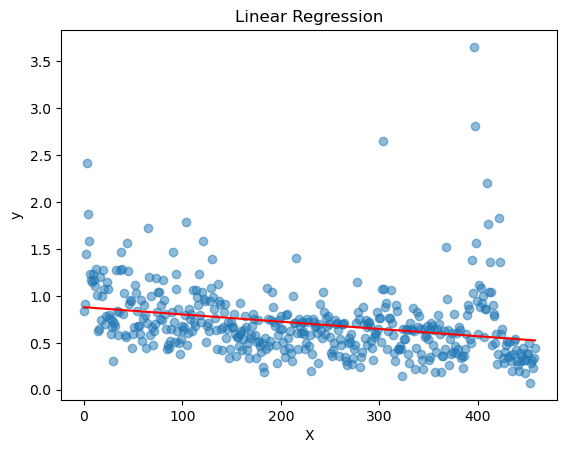

In [29]:
#회귀분석 잘되는지 확인.
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X = np.array(encoded_columns).reshape(-1, 1)
y = np.array(keyword_data.iloc[0,1:]).reshape(-1, 1)


lin_reg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lin_reg.fit(X_train, y_train)

print(lin_reg.intercept_)  #편향(절편)
print(lin_reg.coef_)       #가중치
print(lin_reg.score(X_train, y_train)) #train set 점수
print(lin_reg.score(X_test, y_test)) #test set 점수
plt.scatter(X, y, alpha=0.5)  # 실제 데이터 산점도
plt.plot(X, lin_reg.predict(X), color='red')  # 회귀직선
plt.xlabel("X")
plt.ylabel("y")
plt.title("Linear Regression")
plt.show()

In [30]:
X = np.array(encoded_columns).reshape(-1, 1)
intercepts = [0] * len(keyword_data)
weight = [0] * len(keyword_data)
for i in tqdm(range(len(keyword_data))):
    y = np.array(keyword_data.iloc[i,1:]).reshape(-1, 1)
    lin_reg = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    lin_reg.fit(X_train, y_train)
    intercepts[i]=lin_reg.intercept_
    weight[i]=lin_reg.coef_


  0%|          | 0/3170 [00:00<?, ?it/s]

In [32]:
keyword_data.insert(1,'intercepts',intercepts)
keyword_data.insert(2,'weight',weight)


C:\Users\SJ\AppData\Local\Temp\ipykernel_19060\4032082741.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  keyword_data.insert(1,'intercepts',intercepts)
C:\Users\SJ\AppData\Local\Temp\ipykernel_19060\4032082741.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  keyword_data.insert(2,'weight',weight)


In [33]:
keyword_data = keyword_data.iloc[:, :3]


In [34]:
keyword_data.head()

,브랜드,intercepts,weight
0,B002-00001,[0.8800960629070709],[[-0.0007736371813695518]]
1,B002-00002,[9.695617200157916],[[0.008079537679173276]]
2,B002-00003,[0.5437598075128329],[[0.0010564775479172993]]
3,B002-00005,[2.0341703004093703],[[-0.0008334279531174392]]
4,B002-00006,[0.1984323184630014],[[-0.0001590783139791115]]


In [35]:
train_data = pd.merge(train_data, keyword_data, on='브랜드', how='left')
len(train_data)

15890

In [36]:
sale_data = sale_data.drop(columns=['대분류','중분류','소분류','브랜드'])

In [37]:
sale_data_sum = sale_data.iloc[:,1:].sum(axis=1)
train_data_sum = train_data.iloc[:,5:].sum(axis=1)

In [38]:
product_price = sale_data_sum / train_data_sum
for i in range(len(sale_data)):

    if train_data_sum[i] == 0 :
        product_price[i]=0
    else:
        product_price[i] = sale_data_sum[i] / train_data_sum[i]
    

In [39]:
product_price = list(product_price)

In [40]:
train_data.insert(5,'product_price',product_price)

In [41]:
train_data['product_price'].isnull().sum()

0

In [42]:
train_data['product_price'][train_data['product_price'].isnull()]

Series([], Name: product_price, dtype: object)

In [43]:
train_data = train_data.drop(columns = ['ID'])

In [44]:
# train_data = train_data.iloc[:1000]

In [45]:
temp_intercepts=train_data.iloc[:,-2]
temp_weight=train_data.iloc[:,-1]
train_data=train_data.drop(columns=['intercepts','weight'])
train_data.insert(5,'intercepts',temp_intercepts)
train_data.insert(6,'weight',temp_weight)

In [46]:
train_data.head()

,대분류,중분류,소분류,브랜드,product_price,intercepts,weight,2022-01-01,2022-01-02,2022-01-03,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,[[5474.013344918634]],[0.8800960629070709],[[-0.0007736371813695518]],0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,[[23942.96718943828]],[9.695617200157916],[[0.008079537679173276]],0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,[[12225.177893771763]],[9.695617200157916],[[0.008079537679173276]],0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,[[3981.651925190383]],[9.695617200157916],[[0.008079537679173276]],0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,[[5090.43807872377]],[0.5437598075128329],[[0.0010564775479172993]],0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# 숫자형 변수들의 min-max scaling을 수행하는 코드입니다.
numeric_cols = train_data.columns[7:]
# 칵 column의 min 및 max 계산
min_values = train_data[numeric_cols].min(axis=1)
max_values = train_data[numeric_cols].max(axis=1)
# 각 행의 범위(max-min)를 계산하고, 범위가 0인 경우 1로 대체
ranges = max_values - min_values
ranges[ranges == 0] = 1
# min-max scaling 수행
train_data[numeric_cols] = (train_data[numeric_cols].subtract(min_values, axis=0)).div(ranges, axis=0)
# max와 min 값을 dictionary 형태로 저장
scale_min_dict = min_values.to_dict()
scale_max_dict = max_values.to_dict()

In [48]:
max_price = np.max(train_data.iloc[:,4]).copy()
min_price = np.min(train_data.iloc[:,4]).copy()

for idx in tqdm(range(len(train_data))):
  train_data.iloc[idx,4] = (train_data.iloc[idx,4] - min_price) / (max_price - min_price)

  0%|          | 0/15890 [00:00<?, ?it/s]

In [49]:
max_price = np.max(train_data.iloc[:,5]).copy()
min_price = np.min(train_data.iloc[:,5]).copy()

for idx in tqdm(range(len(train_data))):
    train_data.iloc[idx,5] = (train_data.iloc[idx,5] - min_price) / (max_price - min_price)

  0%|          | 0/15890 [00:00<?, ?it/s]

In [50]:
max_price = np.max(train_data.iloc[:,6]).copy()
min_price = np.min(train_data.iloc[:,6]).copy()

for idx in tqdm(range(len(train_data))):
    train_data.iloc[idx,6] = (train_data.iloc[idx,6] - min_price) / (max_price - min_price)

  0%|          | 0/15890 [00:00<?, ?it/s]

In [51]:
# Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])

In [52]:
train_data.head()

,대분류,중분류,소분류,브랜드,product_price,intercepts,weight,2022-01-01,2022-01-02,2022-01-03,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,1,6,37,0,0.8635664394589492,0.019734100299772444,0.7065705165897915,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,2,7,43,1,0.8635680338539892,0.03149991872808475,0.7117451266184659,0.0,0.0,0.0,...,0.0,0.0,0.0,0.111111,0.333333,0.222222,0.0,0.0,0.222222,0.0
2,2,7,43,1,0.8635670222761116,0.03149991872808475,0.7117451266184659,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,2,7,43,1,0.8635663106257914,0.03149991872808475,0.7117451266184659,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,0,0,2,2,0.8635664063455141,0.019285202129123716,0.707640204038754,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [53]:
train_data = train_data.drop(columns = ['브랜드'])

In [54]:
train_data.head()

,대분류,중분류,소분류,product_price,intercepts,weight,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,1,6,37,0.8635664394589492,0.019734100299772444,0.7065705165897915,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,2,7,43,0.8635680338539892,0.03149991872808475,0.7117451266184659,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.111111,0.333333,0.222222,0.0,0.0,0.222222,0.0
2,2,7,43,0.8635670222761116,0.03149991872808475,0.7117451266184659,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,2,7,43,0.8635663106257914,0.03149991872808475,0.7117451266184659,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,0,0,2,0.8635664063455141,0.019285202129123716,0.707640204038754,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [55]:
def make_train_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    '''
    학습 기간 블럭, 예측 기간 블럭의 세트로 데이터를 생성
    data : 일별 판매량
    train_size : 학습에 활용할 기간
    predict_size : 추론할 기간
    '''
    num_rows = len(data)
    window_size = train_size + predict_size

    input_data = np.empty((num_rows * (len(data.columns) - window_size + 1), train_size, len(data.iloc[0, :6]) + 1))
    target_data = np.empty((num_rows * (len(data.columns) - window_size + 1), predict_size))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :6])
        sales_data = np.array(data.iloc[i, 6:])

        for j in range(len(sales_data) - window_size + 1):
            window = sales_data[j : j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            input_data[i * (len(data.columns) - window_size + 1) + j] = temp_data
            target_data[i * (len(data.columns) - window_size + 1) + j] = window[train_size:]

    return input_data, target_data

In [56]:
def make_predict_data(data, train_size=CFG['TRAIN_WINDOW_SIZE']):
    '''
    평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
    data : 일별 판매량
    train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
    '''
    num_rows = len(data)

    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :6]) + 1))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :6])
        sales_data = np.array(data.iloc[i, -train_size:])

        window = sales_data[-train_size : ]
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data

    return input_data

In [57]:
train_input, train_target = make_train_data(train_data)
test_input = make_predict_data(train_data)

  0%|          | 0/15890 [00:00<?, ?it/s]

  0%|          | 0/15890 [00:00<?, ?it/s]

In [58]:
data_len = len(train_input)
val_input = train_input[-int(data_len*0.2):]
val_target = train_target[-int(data_len*0.2):]
train_input = train_input[:-int(data_len*0.2)]
train_target = train_target[:-int(data_len*0.2)]

In [59]:
train_input.shape, train_target.shape, val_input.shape, val_target.shape, test_input.shape

((4512760, 90, 7),
 (4512760, 21),
 (1128190, 90, 7),
 (1128190, 21),
 (15890, 90, 7))

In [60]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

In [61]:
train_dataset = CustomDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [62]:
class GRU(nn.Module):
    def __init__(self, input_size=7, hidden_size=512, output_size=CFG['PREDICT_SIZE']):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size//2, output_size)
        )

        self.actv = nn.ReLU()# 클래스내에서 사용할수있게 함수를 저장.

    def forward(self, x):
        # x shape: (B, TRAIN_WINDOW_SIZE, 5)
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device) # 90 *512 크기를 생성.

        # LSTM layer
        gru_out, hidden = self.gru(x, hidden)

        # Only use the last output sequence
        last_output = gru_out[:, -1, :] #히든레이어에 들어갈 input

        # Fully connected layer
        output = self.actv(self.fc(last_output))

        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state
        return (torch.zeros(1, batch_size, self.hidden_size, device=device))

In [63]:
def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_loss = 9999999
    best_model = None

    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        train_mae = []
        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)

            optimizer.zero_grad()

            output = model(X)
            loss = criterion(output, Y)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        val_loss = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')

        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            print('Model Saved')
    return best_model

In [64]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []

    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)

            output = model(X)
            loss = criterion(output, Y)

            val_loss.append(loss.item())
    return np.mean(val_loss)

In [65]:
model = GRU()

In [66]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
infer_model = train(model, optimizer, train_loader, val_loader, device) 

  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.01916] Val Loss : [0.01732]
Model Saved


  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.01759] Val Loss : [0.01709]
Model Saved


  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.01740] Val Loss : [0.01690]
Model Saved


  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.01725] Val Loss : [0.01692]


  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.01705] Val Loss : [0.01674]
Model Saved


  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [6] Train Loss : [0.01691] Val Loss : [0.01656]
Model Saved


  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [7] Train Loss : [0.01684] Val Loss : [0.01646]
Model Saved


  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [8] Train Loss : [0.01678] Val Loss : [0.01640]
Model Saved


  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [9] Train Loss : [0.01673] Val Loss : [0.01639]
Model Saved


  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [10] Train Loss : [0.01668] Val Loss : [0.01636]
Model Saved


In [67]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.00005)
infer_model = train(model, optimizer, train_loader, val_loader, device)

  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.01662] Val Loss : [0.01632]
Model Saved


  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.01659] Val Loss : [0.01635]


  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.01657] Val Loss : [0.01632]
Model Saved


  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.01655] Val Loss : [0.01634]


  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.01652] Val Loss : [0.01629]
Model Saved


  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [6] Train Loss : [0.01650] Val Loss : [0.01630]


  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [7] Train Loss : [0.01647] Val Loss : [0.01628]
Model Saved


  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [8] Train Loss : [0.01644] Val Loss : [0.01631]


  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [9] Train Loss : [0.01641] Val Loss : [0.01635]


  0%|          | 0/2204 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : [10] Train Loss : [0.01638] Val Loss : [0.01636]


In [68]:
test_dataset = CustomDataset(test_input, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [69]:
def inference(model, test_loader, device):
    predictions = []

    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(device)

            output = model(X)

            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()

            predictions.extend(output)

    return np.array(predictions)

In [70]:
pred = inference(infer_model, test_loader, device)

  0%|          | 0/8 [00:00<?, ?it/s]

In [71]:
# 추론 결과를 inverse scaling
for idx in range(len(pred)):
    pred[idx, :] = pred[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]

# 결과 후처리
pred = np.round(pred, 0).astype(int)

In [72]:
pred.shape

(15890, 21)

In [73]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
submit.iloc[:,1:] = pred
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1


In [75]:
submit.to_csv('./12345.csv', index=False)